## 🧩 Análise de Biblioteca de Meta-Átomos – Heatmaps e Casamento de Fase  
## Meta-Atom Library Analysis – Heatmaps and Phase Matching  

---

### Objetivo (PT)  
Este notebook demonstra o fluxo completo de **leitura, limpeza e análise** de uma **biblioteca de meta-átomos simulada** a partir de arquivos **Touchstone** (`.ts`, `.s4p`, `.sNp`). O processo envolve a extração de parâmetros S, o cálculo de colunas derivadas de **amplitude** e **fase** para polarizações **TE/TM**, e a visualização por meio de **mapas de calor**.  
Os resultados permitem avaliar a continuidade espacial da resposta e selecionar regiões da biblioteca compatíveis com o **casamento de fase** necessário à síntese de hologramas multiplexados, conforme a metodologia apresentada em **Guo et al. (2025)** e no Capítulo 4 da monografia.

### Objective (EN)  
This notebook demonstrates the full workflow for **reading, cleaning, and analyzing** a simulated **meta-atom library** from **Touchstone** files (`.ts`, `.s4p`, `.sNp`). The process includes extraction of S-parameters, computation of derived **amplitude** and **phase** for **TE/TM** polarizations, and visualization through **heatmaps**.  
These results allow assessing the spatial continuity of the optical response and selecting regions suitable for **phase matching** in multiplexed hologram synthesis, following **Guo et al. (2025)** and Chapter 4 of the thesis.

---

### 💾 Saídas / Outputs
| Tipo | Descrição | Local |
|------|------------|--------|
| 📊 Biblioteca processada (`.csv`/`.parquet`) | Dados limpos e derivados (|T|, fase TE/TM) | `results/meta_library/library_clean/<run_id>/...` |
| 🗺️ Mapas de calor (`.png`) | Fase e amplitude TE/TM em função de Lₓ×Lᵧ | `results/meta_library/heatmaps/<run_id>/...` |
| 📈 Gráficos auxiliares | Distribuição de frequências, NaNs, etc. | `results/meta_library/analysis/<run_id>/...` |

---

### 1. 🧭 Detecção automática da raiz do repositório  
**PT** — Esta célula localiza automaticamente o diretório-raiz do projeto (aquele que contém a pasta `src/`).  
- Sobe recursivamente até encontrar `src/` e adiciona esse caminho ao `sys.path`.  
- Assim, é possível importar módulos como `meta_library.generate_df` diretamente, independentemente da pasta em que o notebook for executado.  
- O resultado impresso confirma o caminho detectado e se ele já estava no `sys.path`.

In [2]:
import sys
from pathlib import Path

# Descobre a raiz do repo subindo pastas até achar "src"
repo_root = Path.cwd()
while not (repo_root / "src").exists() and repo_root != repo_root.parent:
    repo_root = repo_root.parent

print("Repo root detectado:", repo_root)

# Adiciona src/ ao sys.path
src_path = repo_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))
    print("Adicionado ao sys.path:", src_path)
else:
    print("src já estava no sys.path:", src_path)

Repo root detectado: c:\Users\vinicius23011\MATLAB\Projects\TCC
Adicionado ao sys.path: c:\Users\vinicius23011\MATLAB\Projects\TCC\src


### 2. ⚙️ Importações e módulos utilizados  
**PT** — Nesta etapa são importadas as bibliotecas fundamentais:  
- `numpy` e `pandas` para manipulação numérica e tabular;  
- `matplotlib.pyplot` e `seaborn` para visualização;  
- funções do projeto:  
  - `touchstone_to_dataframe` → converte diretórios de arquivos Touchstone em DataFrames;  
  - `append_derived_columns` → adiciona amplitude (|T|) e fase para TE e TM;  
  - `compute_heatmaps` → organiza os dados limpos em grids (Lₓ×Lᵧ).  


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from meta_library.generate_df import touchstone_to_dataframe
from meta_library.clean_library import append_derived_columns
from meta_library.phase_matching import compute_heatmaps


### 3. 📁 Leitura da biblioteca Touchstone  
**PT** — Define o diretório contendo os arquivos `.ts`/`.s4p` simulados e executa  
`touchstone_to_dataframe(folder)`.  
O parser percorre todos os arquivos, lê seus cabeçalhos (dimensões Lₓ, Lᵧ, H se disponíveis) e extrai os S-parâmetros relevantes.  
O resultado é um `DataFrame` com colunas como:

| Coluna | Descrição |
|---------|------------|
| `L_x`, `L_y`, `H` | Parâmetros geométricos do meta-átomo |
| `frequencia_ghz` | Frequência da simulação |
| `S13_real/imag`, `S24_real/imag` | Componentes reais e imaginárias de TE/TM |

In [4]:
folder = r"C:\Users\vinicius23011\MATLAB\Projects\TCC\Bibliotecas\Bib1-27x27-perdas"
df_raw = touchstone_to_dataframe(folder)


2025-11-14 20:09:01,462 - meta_library.generate_df - INFO - Procurando arquivos Touchstone em C:\Users\vinicius23011\MATLAB\Projects\TCC\Bibliotecas\Bib1-27x27-perdas (recursive=False)...
2025-11-14 20:09:01,518 - meta_library.generate_df - INFO - Encontrados 729 arquivos Touchstone
2025-11-14 20:09:01,527 - meta_library.generate_df - INFO - Lendo arquivo: Teste_Nanopilar_1.ts (ID:1)...
2025-11-14 20:09:01,745 - meta_library.generate_df - INFO - Lendo arquivo: Teste_Nanopilar_10.ts (ID:10)...
2025-11-14 20:09:01,955 - meta_library.generate_df - INFO - Lendo arquivo: Teste_Nanopilar_100.ts (ID:100)...
2025-11-14 20:09:02,165 - meta_library.generate_df - INFO - Lendo arquivo: Teste_Nanopilar_101.ts (ID:101)...
2025-11-14 20:09:02,390 - meta_library.generate_df - INFO - Lendo arquivo: Teste_Nanopilar_102.ts (ID:102)...
2025-11-14 20:09:02,634 - meta_library.generate_df - INFO - Lendo arquivo: Teste_Nanopilar_103.ts (ID:103)...
2025-11-14 20:09:02,874 - meta_library.generate_df - INFO - Le

### 4. 🎯 Seleção de frequência alvo  
**PT** — Filtra a biblioteca para uma **frequência específica** de interesse (ex.: 281.76 GHz, correspondente a λ ≈ 1064 nm).  
Essa etapa gera um subconjunto 2D (`Lₓ×Lᵧ`) de parâmetros para uma única frequência — análogo a um plano de corte espectral.

In [5]:
freq_target = 281760.0
df_1064 = df_raw[np.isclose(df_raw["frequencia_ghz"], freq_target)].copy()

df_1064.head()


,arquivo,caminho,id_nanopilar,frequencia_hz,frequencia_ghz,nports,H,L_x,L_y,Lambda,...,S34_real,S34_imag,S41_real,S41_imag,S42_real,S42_imag,S43_real,S43_imag,S44_real,S44_imag
572,Teste_Nanopilar_1.ts,C:\Users\vinicius23011\MATLAB\Projects\TCC\Bib...,1,2.817572e+14,281757.2,4,600.0,70.0,70.0,1064.0,...,0.000116,-0.00045,-0.000207,-0.000124,-0.986184,0.059242,0.000181,-0.0004,-0.095333,0.120610
573,Teste_Nanopilar_1.ts,C:\Users\vinicius23011\MATLAB\Projects\TCC\Bib...,1,2.817573e+14,281757.3,4,600.0,70.0,70.0,1064.0,...,0.000116,-0.00045,-0.000207,-0.000124,-0.986183,0.059268,0.000181,-0.0004,-0.095329,0.120609
574,Teste_Nanopilar_1.ts,C:\Users\vinicius23011\MATLAB\Projects\TCC\Bib...,1,2.817574e+14,281757.4,4,600.0,70.0,70.0,1064.0,...,0.000116,-0.00045,-0.000207,-0.000124,-0.986182,0.059294,0.000180,-0.0004,-0.095325,0.120609
575,Teste_Nanopilar_1.ts,C:\Users\vinicius23011\MATLAB\Projects\TCC\Bib...,1,2.817575e+14,281757.5,4,600.0,70.0,70.0,1064.0,...,0.000116,-0.00045,-0.000207,-0.000124,-0.986181,0.059320,0.000180,-0.0004,-0.095320,0.120608
576,Teste_Nanopilar_1.ts,C:\Users\vinicius23011\MATLAB\Projects\TCC\Bib...,1,2.817576e+14,281757.6,4,600.0,70.0,70.0,1064.0,...,0.000116,-0.00045,-0.000207,-0.000124,-0.986180,0.059346,0.000180,-0.0004,-0.095316,0.120607


### 5. 🧮 Cálculo de colunas derivadas (|T| e fase TE/TM)  
**PT** — A função `append_derived_columns` calcula a amplitude e fase complexa dos parâmetros S, obtendo:  
- `amp_TE`, `phase_TE` a partir de `S13`;  
- `amp_TM`, `phase_TM` a partir de `S24`.  
Opcionalmente, podem ser criadas colunas complexas `S_complex_TE/TM`.  
Essas grandezas são essenciais para o casamento de fase entre polarizações e a análise de eficiência de transmissão.

In [6]:
df_1064 = append_derived_columns(
    df_1064,
    te_cols=("S13_real", "S13_imag"),  # TE = S13
    tm_cols=("S24_real", "S24_imag"),  # TM = S24
    unwrap_phase=False,
    phase_unit="rad"
)


2025-11-14 20:12:10,041 - meta_library.clean_library - INFO - Calculando colunas derivadas de TE=('S13_real', 'S13_imag'), TM=('S24_real', 'S24_imag')
2025-11-14 20:12:10,097 - meta_library.clean_library - INFO - Colunas adicionadas: amp_TE, phase_TE, amp_TM, phase_TM, S_complex_TE, S_complex_TM



### 6. 🗺️ Construção dos mapas de calor  
**PT** — Ordena as dimensões Lₓ e Lᵧ, gera o grid completo e usa `compute_heatmaps` para calcular as matrizes correspondentes de **fase** e **amplitude** (TE e TM).  
O resultado são arrays 2D que descrevem a resposta óptica espacial do conjunto de meta-átomos.  
Cada mapa representa a continuidade das propriedades eletromagnéticas sobre o domínio geométrico.


In [7]:
xs = np.sort(df_1064["L_x"].unique())
ys = np.sort(df_1064["L_y"].unique())

heatmaps = compute_heatmaps(
    df_1064,
    x="L_x",
    y="L_y",
    fields=("phase_TE", "amp_TE", "phase_TM", "amp_TM"),
    bins_x=len(xs),
    bins_y=len(ys),
)

phase_TE = heatmaps["phase_TE"]
amp_TE   = heatmaps["amp_TE"]
phase_TM = heatmaps["phase_TM"]
amp_TM   = heatmaps["amp_TM"]
x_grid   = heatmaps["x_grid"]
y_grid   = heatmaps["y_grid"]


2025-11-14 20:12:15,962 - meta_library.phase_matching - INFO - Calculando mapas de calor para 4 campos sobre L_x x L_y
2025-11-14 20:12:15,986 - meta_library.phase_matching - INFO -   Interpolando phase_TE...
2025-11-14 20:12:16,212 - meta_library.phase_matching - INFO -   Interpolando amp_TE...
2025-11-14 20:12:16,349 - meta_library.phase_matching - INFO -   Interpolando phase_TM...
2025-11-14 20:12:16,445 - meta_library.phase_matching - INFO -   Interpolando amp_TM...
2025-11-14 20:12:16,616 - meta_library.phase_matching - INFO - Mapas de calor calculados com sucesso (grade 27x27)


### 7. 🧱 Conversão para DataFrame e verificação de lacunas  
**PT** — Converte cada matriz em `DataFrame` rotulado, com Lᵧ como índice e Lₓ como colunas.  
Isso facilita o uso do `seaborn.heatmap`.  
Em seguida, é feita uma verificação de **valores ausentes (NaNs)**, indicando regiões não simuladas ou falhas no grid.


In [8]:
# --- 5) Empacotar em DataFrames com rótulos de eixo (facilita o seaborn.heatmap) ---
df_phase_TE = pd.DataFrame(phase_TE, index=y_grid, columns=x_grid)
df_amp_TE   = pd.DataFrame(amp_TE,   index=y_grid, columns=x_grid)
df_phase_TM = pd.DataFrame(phase_TM, index=y_grid, columns=x_grid)
df_amp_TM   = pd.DataFrame(amp_TM,   index=y_grid, columns=x_grid)

# Opcional: verificar NaNs
for name, mat in {
    "phase_TE": df_phase_TE, "amp_TE": df_amp_TE,
    "phase_TM": df_phase_TM, "amp_TM": df_amp_TM
}.items():
    n_nans = np.isnan(mat.values).sum()
    if n_nans:
        print(f"Atenção: {name} contém {n_nans} valores NaN (origem: lacunas no grid).")


### 8. 🎨 Definição de funções de plotagem  
**PT** — Define funções utilitárias para exibir os mapas de calor de **fase** e **transmitância**, com padronização de cores e eixos.  
- `plot_phase` exibe a fase em radianos [–π, π] com escala cromática `jet`.  
- `plot_transmittance` exibe a magnitude (|T|² ou |T|) em [0.7, 1.0].  
Essas funções seguem a convenção usada nos notebooks de holografia (aspecto quadrado, títulos consistentes).


In [9]:
# --- 6) Funções de plotagem: estética consistente + barras de cor padronizadas ---
def _set_square_axes(ax, xlabel="L_x (nm)", ylabel="L_y (nm)", title=None):
    """Pequeno helper para padronizar layout."""
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    if title:
        ax.set_title(title, fontsize=16)
    # Deixar as células "quadradas" visualmente (opcional, depende de proporções do grid):
    ax.set_aspect("equal", adjustable="box")

def plot_phase(df_phase, title="Phase", cmap="jet", vmin=-np.pi, vmax=np.pi):
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        df_phase,
        annot=False,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        linewidths=0.5,
        linecolor="black",
        cbar_kws={"ticks": [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]}
    )
    # Ajustar rótulos da barra de cores para π
    cbar = ax.collections[0].colorbar
    cbar.set_ticklabels([r"$-\pi$", r"$-\pi/2$", "0", r"$\pi/2$", r"$\pi$"])
    _set_square_axes(ax, title=title)
    plt.tight_layout()
    plt.show()

def plot_transmittance(df_amp, title="Transmittance", cmap="jet", vmin=0.7, vmax=1.0):
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        df_amp,
        annot=False,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        linewidths=0.5,
        linecolor="black",
        cbar_kws={"ticks": [vmin, 0.8, 0.9, vmax]}
    )
    _set_square_axes(ax, title=title)
    plt.tight_layout()
    plt.show()



### 9. 📈 Visualização final dos resultados  
**PT** — Gera quatro figuras finais:  
1. **Fase TE** – variação de fase entre meta-átomos para polarização TE.  
2. **Transmitância TE** – magnitude da transmissão TE.  
3. **Transmitância TM** – magnitude da transmissão TM.  
4. **Fase TM** – variação de fase entre meta-átomos TM.  

Esses gráficos permitem comparar continuidade e eficiência de ambas as polarizações, sendo a base para o cálculo de **erros de casamento de fase** utilizados na síntese holográfica.

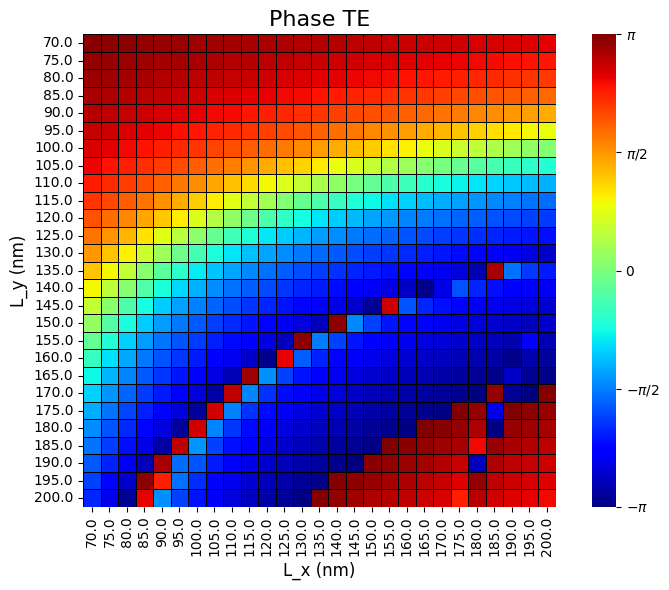

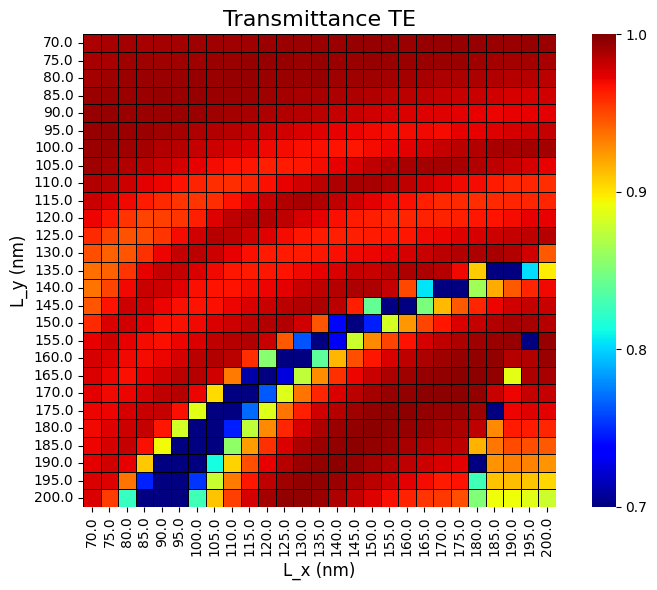

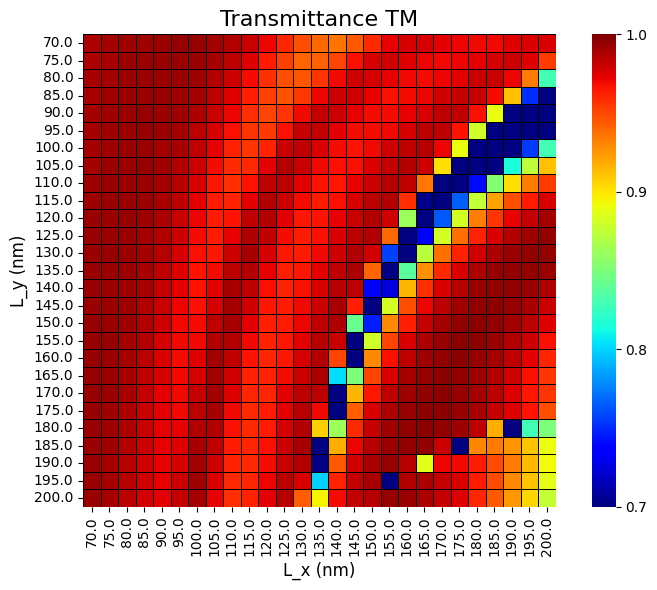

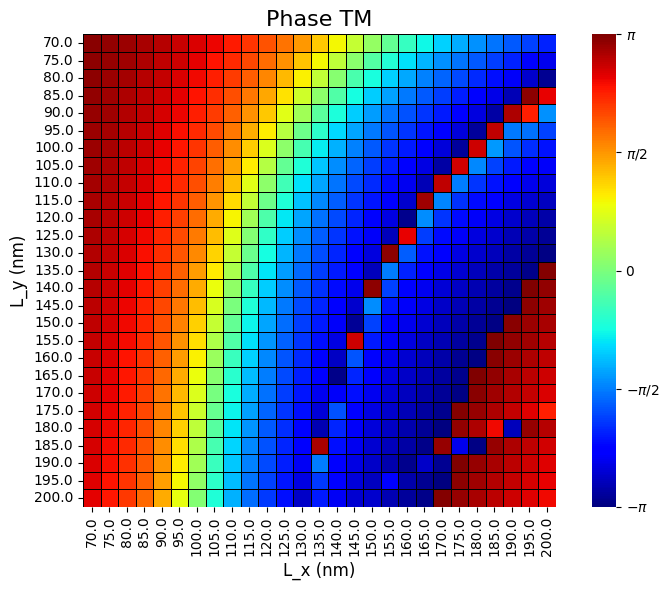

In [10]:
# --- 7) Plots finais (sem reprocessar nada) ---
plot_phase(df_phase_TE, title="Phase TE")
plot_transmittance(df_amp_TE, title="Transmittance TE")

plot_transmittance(df_amp_TM, title="Transmittance TM")
plot_phase(df_phase_TM, title="Phase TM")


## 10) 🔧 Funções utilitárias para métricas
**PT** — Define utilitários numéricos usados nas próximas células:
- `_nan_stats`: contagem de pontos válidos vs. `NaN` (cobertura do grid).
- `_phase_coverage`: intervalo de fase `[min, max]` e **span** (idealmente próximo de `2π`).
- `_mean_std`: média e desvio-padrão (p. ex., |T| médio e sua homogeneidade).
- `_grad_smoothness`: **suavidade de fase** como ⟨‖∇ϕ‖⟩; menor é melhor (contínuo).
- `_corr`: correlação de Pearson entre duas matrizes (ex.: fase × amplitude).


In [11]:
def _nan_stats(arr):
    vals = np.asarray(arr).astype(float)
    n_tot = vals.size
    n_nan = np.isnan(vals).sum()
    n_ok  = n_tot - n_nan
    return {"n_tot": int(n_tot), "n_nan": int(n_nan), "n_ok": int(n_ok), "nan_pct": 100*n_nan/max(n_tot,1)}

def _phase_coverage(arr):
    a = np.asarray(arr)
    a = a[~np.isnan(a)]
    if a.size == 0: 
        return {"min": np.nan, "max": np.nan, "span": np.nan}
    return {"min": float(a.min()), "max": float(a.max()), "span": float(a.max()-a.min())}

def _mean_std(arr):
    a = np.asarray(arr)
    a = a[~np.isnan(a)]
    if a.size == 0: 
        return {"mean": np.nan, "std": np.nan}
    return {"mean": float(np.mean(a)), "std": float(np.std(a))}

def _grad_smoothness(arr):
    """Suavidade de fase: média do módulo do gradiente (quanto menor, mais suave)."""
    a = np.asarray(arr)
    if a.ndim != 2:
        return np.nan
    gx, gy = np.gradient(np.nan_to_num(a, nan=np.nanmean(a)))
    return float(np.mean(np.sqrt(gx*gx + gy*gy)))

def _corr(a, b):
    a = np.asarray(a).flatten()
    b = np.asarray(b).flatten()
    mask = np.isfinite(a) & np.isfinite(b)
    if mask.sum() < 2: 
        return np.nan
    return float(np.corrcoef(a[mask], b[mask])[0,1])

## 11) 📐 Métricas ópticas (TE/TM) & acoplamento fase–amplitude
**PT** — A partir dos DataFrames de heatmap (`df_phase_TE`, `df_amp_TE`, etc.), avaliamos:
- **Transmitância média/σ** (qualidade e uniformidade óptica);
- **Cobertura de fase** (ideal: próximo a `2π`);
- **Suavidade de fase** (⟨‖∇ϕ‖⟩ menor → variação contínua);
- **NaNs** (lacunas do grid);
- **Correlação ϕ↔|T|** (idealmente baixa; evita *trade-offs* indesejados).


In [12]:
# Flatten para estatísticas
phase_TE_vals = df_phase_TE.values
phase_TM_vals = df_phase_TM.values
amp_TE_vals   = df_amp_TE.values
amp_TM_vals   = df_amp_TM.values

print("=== MÉTRICAS ÓPTICAS (TE) ===")
print("Transmittance TE:", _mean_std(amp_TE_vals))
print("Phase TE coverage:", _phase_coverage(phase_TE_vals))
print("Phase TE smoothness (mean |∇phase|):", _grad_smoothness(phase_TE_vals))
print("NaNs TE phase/amp:", {"phase": _nan_stats(phase_TE_vals), "amp": _nan_stats(amp_TE_vals)})
print()

print("=== MÉTRICAS ÓPTICAS (TM) ===")
print("Transmittance TM:", _mean_std(amp_TM_vals))
print("Phase TM coverage:", _phase_coverage(phase_TM_vals))
print("Phase TM smoothness (mean |∇phase|):", _grad_smoothness(phase_TM_vals))
print("NaNs TM phase/amp:", {"phase": _nan_stats(phase_TM_vals), "amp": _nan_stats(amp_TM_vals)})
print()

print("=== ACOPLAMENTO AMPLITUDE–FASE ===")
print("corr(phase_TE, amp_TE):", _corr(phase_TE_vals, amp_TE_vals))
print("corr(phase_TM, amp_TM):", _corr(phase_TM_vals, amp_TM_vals))


=== MÉTRICAS ÓPTICAS (TE) ===
Transmittance TE: {'mean': 0.9445144739757108, 'std': 0.12344926770232383}
Phase TE coverage: {'min': -3.141494210458131, 'max': 3.120821459197769, 'span': 6.2623156696559}
Phase TE smoothness (mean |∇phase|): 0.6372022335077719
NaNs TE phase/amp: {'phase': {'n_tot': 729, 'n_nan': 0, 'n_ok': 729, 'nan_pct': 0.0}, 'amp': {'n_tot': 729, 'n_nan': 0, 'n_ok': 729, 'nan_pct': 0.0}}

=== MÉTRICAS ÓPTICAS (TM) ===
Transmittance TM: {'mean': 0.9443938129618411, 'std': 0.12374450005068444}
Phase TM coverage: {'min': -3.137832870720431, 'max': 3.125000701468669, 'span': 6.2628335721891}
Phase TM smoothness (mean |∇phase|): 0.6375974627330924
NaNs TM phase/amp: {'phase': {'n_tot': 729, 'n_nan': 0, 'n_ok': 729, 'nan_pct': 0.0}, 'amp': {'n_tot': 729, 'n_nan': 0, 'n_ok': 729, 'nan_pct': 0.0}}

=== ACOPLAMENTO AMPLITUDE–FASE ===
corr(phase_TE, amp_TE): 0.0709636125362461
corr(phase_TM, amp_TM): 0.0709061618226622


## 12) Histogramas & correlação geométrica × óptica
**PT** — Dois blocos:
1. **Histogramas** de ϕ e |T| (TE/TM) para avaliar distribuição e assimetrias;  
2. **Matriz de correlação** entre `L_x`, `L_y` e grandezas ópticas (`phase_*`, `amp_*`) — mostra sensibilidade de ϕ/|T| às dimensões (ex., dominância de `L_x` vs `L_y`).

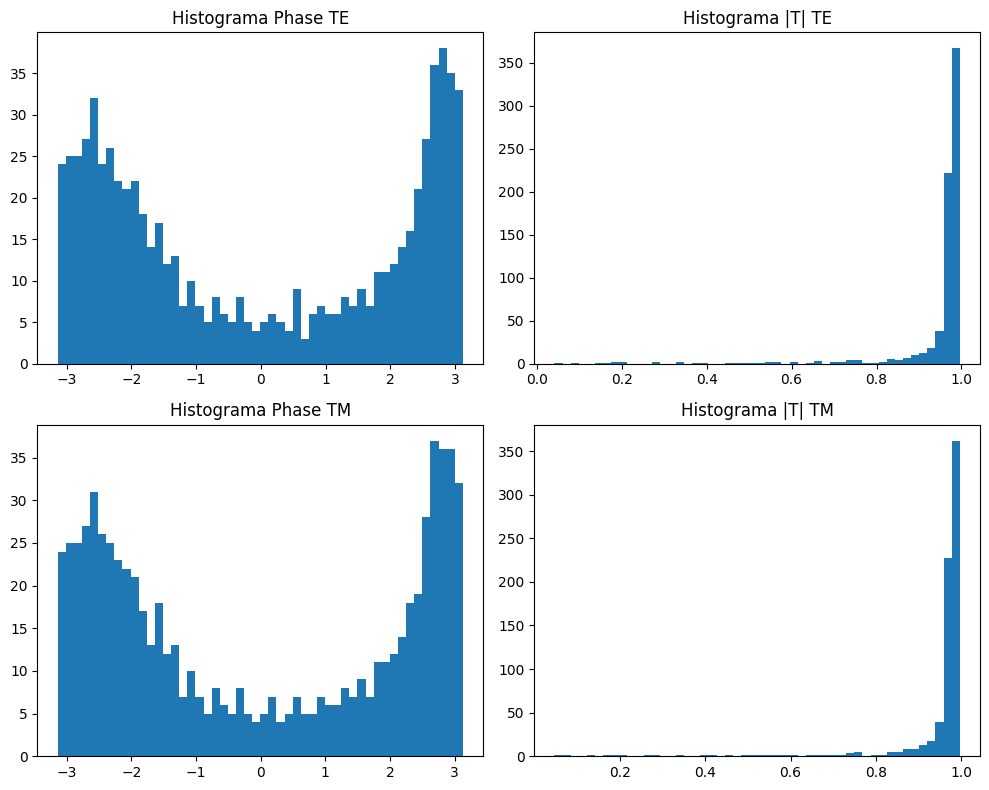

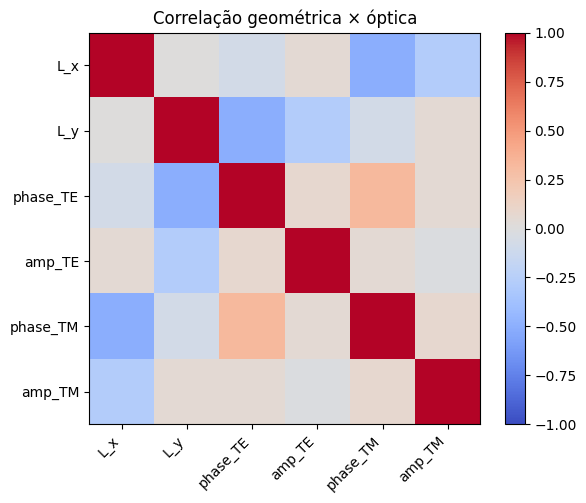

Correlação (amostra):


,L_x,L_y,phase_TE,amp_TE,phase_TM,amp_TM
L_x,1.000,0.000,-0.077,0.049,-0.507,-0.275
L_y,0.000,1.000,-0.502,-0.275,-0.078,0.048
phase_TE,-0.077,-0.502,1.000,0.072,0.324,0.050
amp_TE,0.049,-0.275,0.072,1.000,0.048,-0.023
phase_TM,-0.507,-0.078,0.324,0.048,1.000,0.070
amp_TM,-0.275,0.048,0.050,-0.023,0.070,1.000


In [13]:
# Histogramas
fig, axes = plt.subplots(2, 2, figsize=(10,8))
axes = axes.ravel()

axes[0].hist(phase_TE_vals.flatten(), bins=50)
axes[0].set_title("Histograma Phase TE")
axes[1].hist(amp_TE_vals.flatten(), bins=50)
axes[1].set_title("Histograma |T| TE")
axes[2].hist(phase_TM_vals.flatten(), bins=50)
axes[2].set_title("Histograma Phase TM")
axes[3].hist(amp_TM_vals.flatten(), bins=50)
axes[3].set_title("Histograma |T| TM")
plt.tight_layout()
plt.show()

# Correlação entre parâmetros geométricos e ópticos (se colunas existirem)
cols = []
for c in ["L_x","L_y"]:
    if c in df_1064.columns: cols.append(c)
for c in ["phase_TE","amp_TE","phase_TM","amp_TM"]:
    cols.append(c)
df_corr = df_1064[cols].dropna()
corrmat = df_corr.corr()

plt.figure(figsize=(6,5))
im = plt.imshow(corrmat, cmap="coolwarm", vmin=-1, vmax=1)
plt.xticks(range(len(corrmat.columns)), corrmat.columns, rotation=45, ha="right")
plt.yticks(range(len(corrmat.index)), corrmat.index)
plt.title("Correlação geométrica × óptica")
plt.colorbar(im)
plt.tight_layout()
plt.show()

print("Correlação (amostra):")
display(corrmat.round(3))


## 13) 🧾 Tabela-resumo (TE/TM)
**PT** — Consolida as principais métricas em uma **tabela única** por canal (TE/TM):
- `amp_mean`, `amp_std`  
- `phase_min`, `phase_max`, `phase_span`  
- `phase_smoothness` (⟨‖∇ϕ‖⟩)  
- porcentagem de `NaN` em fase/|T|  
- `corr(phase,amp)`

> Uso: exporte `summary_df.to_csv(...)` para versionar resultados de qualidade da biblioteca.


In [14]:
summary_rows = []

def _summ_line(name, arr_phase, arr_amp):
    m_amp = _mean_std(arr_amp)
    pcov  = _phase_coverage(arr_phase)
    smth  = _grad_smoothness(arr_phase)
    summary_rows.append({
        "canal": name,
        "amp_mean": m_amp["mean"],
        "amp_std": m_amp["std"],
        "phase_min": pcov["min"],
        "phase_max": pcov["max"],
        "phase_span": pcov["span"],
        "phase_smoothness": smth,
        "nan_phase_pct": _nan_stats(arr_phase)["nan_pct"],
        "nan_amp_pct": _nan_stats(arr_amp)["nan_pct"],
        "corr(phase,amp)": _corr(arr_phase, arr_amp),
    })

_summ_line("TE", phase_TE_vals, amp_TE_vals)
_summ_line("TM", phase_TM_vals, amp_TM_vals)

summary_df = pd.DataFrame(summary_rows)
display(summary_df.round(4))


,canal,amp_mean,amp_std,phase_min,phase_max,phase_span,phase_smoothness,nan_phase_pct,nan_amp_pct,"corr(phase,amp)"
0,TE,0.9445,0.1234,-3.1415,3.1208,6.2623,0.6372,0.0,0.0,0.0710
1,TM,0.9444,0.1237,-3.1378,3.1250,6.2628,0.6376,0.0,0.0,0.0709
